In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime
import os
# Data Manipulation
import numpy as np
import pandas as pd
import datetime

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
#Reading data files and parsing dates (automated date recognition)
dftrain0 = pd.read_csv('data/train_users_2.csv',parse_dates=['timestamp_first_active', 'date_account_created', 'date_first_booking'])
dftest = pd.read_csv('data/test_users.csv',parse_dates=['timestamp_first_active', 'date_account_created', 'date_first_booking'])
dfsessions = pd.read_csv('data/sessions.csv')
dfcountries = pd.read_csv('data/countries.csv')

dfage_gender = pd.read_csv('data/age_gender_bkts.csv')
dftrain0

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [3]:
#Merge test and train to clean data
test_ids = dftest['id']
Nrows_train = dftrain0.shape[0]  


dftrain = pd.concat((dftrain0, dftest), axis = 0, ignore_index = True)
dftrain

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaT,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,2009-03-19 04:32:55
1,seo,google,38.0,NDF,2011-05-25,NaT,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,2009-05-23 17:48:09
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,2009-06-09 23:12:47
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,2009-10-31 06:01:29
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,2009-12-08 06:11:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,direct,direct,31.0,NaN,2014-09-30,NaT,untracked,IE,Windows Desktop,-unknown-,cv0na2lf5a,en,Web,0,basic,2014-09-30 23:52:32
275543,direct,direct,NaN,NaN,2014-09-30,NaT,untracked,-unknown-,Android Phone,-unknown-,zp8xfonng8,ko,Android,23,basic,2014-09-30 23:53:06
275544,direct,direct,NaN,NaN,2014-09-30,NaT,linked,Firefox,Windows Desktop,-unknown-,fa6260ziny,de,Web,0,basic,2014-09-30 23:54:08
275545,sem-brand,google,NaN,NaN,2014-09-30,NaT,omg,Safari,Mac Desktop,-unknown-,87k0fy4ugm,en,Web,0,basic,2014-09-30 23:54:30


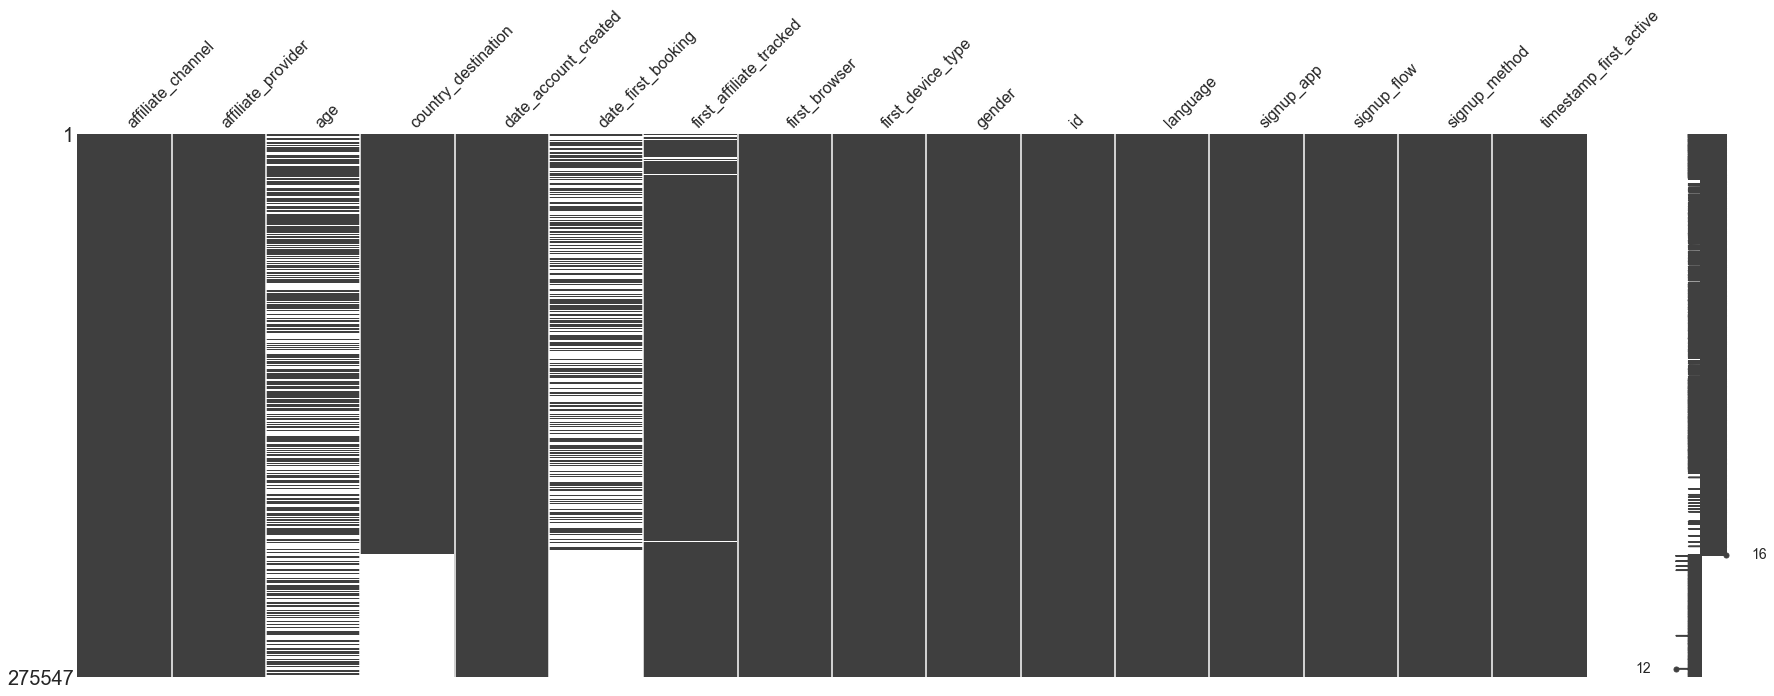

In [4]:
# Plot graphic of missing values
missingno.matrix(dftrain, figsize = (30,10))

#We can see that alot of the missing values come from date_first_booking and age

In [5]:
#Replace gender = -unknow- with NaN since it is recognized by python as a missing value
dftrain.gender.replace('-unknown-', np.nan, inplace=True)
dftrain.first_browser.replace('-unknown-', np.nan, inplace=True)

In [6]:
#Remove any age outliers, for example one outlier was 2014 which is a data entry error.
dftrain.loc[dftrain.age > 100, 'age'] = np.nan
dftrain.loc[dftrain.age < 18, 'age'] = np.nan


In [7]:
#Check how much data we would lose from removing missing values in "data_first_booking"
total = dftrain.isnull().sum().sort_values(ascending=False)
percent = (dftrain.isnull().sum()/dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(1)

,Total,Percent
date_first_booking,186639,0.67734


In [8]:
#Number of observations with missing values
dftrain['id'].count()

275547

In [9]:
#Remove all rows with missing values
dftrain = dftrain.dropna()

In [10]:
#Number of observations without missing values
dftrain['id'].count()

51530

In [11]:
#Creating age brackets
bins = [18, 30, 40, 50, 60, 70, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
#smaller brackets
dftrain['agerange'] = pd.cut(dftrain.age, bins, labels = labels,include_lowest = True)
dftrain.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active,agerange
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,2009-06-09 23:12:47,50-59
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,2009-10-31 06:01:29,40-49
6,other,craigslist,46.0,US,2010-01-02,2010-01-05,untracked,Safari,Mac Desktop,FEMALE,lsw9q7uk0j,en,Web,0,basic,2010-01-02 01:25:58,40-49
7,direct,direct,47.0,US,2010-01-03,2010-01-13,omg,Safari,Mac Desktop,FEMALE,0d01nltbrs,en,Web,0,basic,2010-01-03 19:19:05,40-49
8,other,craigslist,50.0,US,2010-01-04,2010-07-29,untracked,Safari,Mac Desktop,FEMALE,a1vcnhxeij,en,Web,0,basic,2010-01-04 00:42:11,40-49


In [12]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51530 entries, 2 to 213445
Data columns (total 17 columns):
affiliate_channel          51530 non-null object
affiliate_provider         51530 non-null object
age                        51530 non-null float64
country_destination        51530 non-null object
date_account_created       51530 non-null datetime64[ns]
date_first_booking         51530 non-null datetime64[ns]
first_affiliate_tracked    51530 non-null object
first_browser              51530 non-null object
first_device_type          51530 non-null object
gender                     51530 non-null object
id                         51530 non-null object
language                   51530 non-null object
signup_app                 51530 non-null object
signup_flow                51530 non-null int64
signup_method              51530 non-null object
timestamp_first_active     51530 non-null datetime64[ns]
agerange                   51530 non-null category
dtypes: category(1), datetime64

In [13]:
#Creatin binary dummy variables with the categorical variables
bingender = pd.get_dummies(dftrain['gender'])
binlanguage = pd.get_dummies(dftrain['language'],dummy_na=False)
binchannel = pd.get_dummies(dftrain['affiliate_channel'],dummy_na=False)
binprovider = pd.get_dummies(dftrain['affiliate_provider'],dummy_na=False)
bindevice = pd.get_dummies(dftrain['first_device_type'],dummy_na=False)
binbrowser = pd.get_dummies(dftrain['first_browser'],dummy_na=False)
bincountry = pd.get_dummies(dftrain['country_destination'],dummy_na=False)
binmethod = pd.get_dummies(dftrain['signup_method'],dummy_na=False)
binapp = pd.get_dummies(dftrain['signup_app'],dummy_na=False)
binage = pd.get_dummies(dftrain['agerange'],dummy_na=False)

In [14]:
#create a new clean dataframe to work without the categorical data while still preserving previous data
dftrainclean = pd.concat([dftrain,bingender,binlanguage,bincountry,binchannel,binprovider,bindevice,binbrowser,binmethod,binapp,binage],axis=1)

#del dftrainclean['gender']
#del dftrainclean['language']
del dftrainclean['affiliate_provider']
del dftrainclean['first_device_type']
del dftrainclean['first_browser']
#del dftrainclean['country_destination']
del dftrainclean['first_affiliate_tracked']
del dftrainclean['signup_method']
del dftrainclean['affiliate_channel']
del dftrainclean['signup_app']
del dftrainclean['signup_flow']
del dftrainclean['id']
#del dftrainclean['age']
del dftrainclean['agerange']
del dftrainclean['OTHER']
del dftrainclean['date_first_booking']

# Splitting date time data for date account created
dftrainclean['dac_year'] = dftrainclean.date_account_created.dt.year
dftrainclean['dac_month'] = dftrainclean.date_account_created.dt.month
dftrainclean['dac_day'] = dftrainclean.date_account_created.dt.day

# Splitting date time data for time first active
dftrainclean['tfa_year'] = dftrainclean.timestamp_first_active.dt.year
dftrainclean['tfa_month'] = dftrainclean.timestamp_first_active.dt.month
dftrainclean['tfa_day'] = dftrainclean.timestamp_first_active.dt.day

dftrainclean.drop('date_account_created',1, inplace=True)
dftrainclean.drop('timestamp_first_active',1, inplace=True)

dftrainclean.head()

,age,country_destination,gender,language,FEMALE,MALE,ca,cs,da,de,...,40-49,50-59,60-69,70+,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
2,56.0,US,FEMALE,en,1,0,0,0,0,0,...,0,1,0,0,2010,9,28,2009,6,9
3,42.0,other,FEMALE,en,1,0,0,0,0,0,...,1,0,0,0,2011,12,5,2009,10,31
6,46.0,US,FEMALE,en,1,0,0,0,0,0,...,1,0,0,0,2010,1,2,2010,1,2
7,47.0,US,FEMALE,en,1,0,0,0,0,0,...,1,0,0,0,2010,1,3,2010,1,3
8,50.0,US,FEMALE,en,1,0,0,0,0,0,...,1,0,0,0,2010,1,4,2010,1,4


Gender Percentage:
 FEMALE    53.551329
MALE      46.167281
OTHER      0.281389
Name: gender, dtype: float64

Gender Count:
 gender
FEMALE    27595
MALE      23790
OTHER       145
dtype: int64


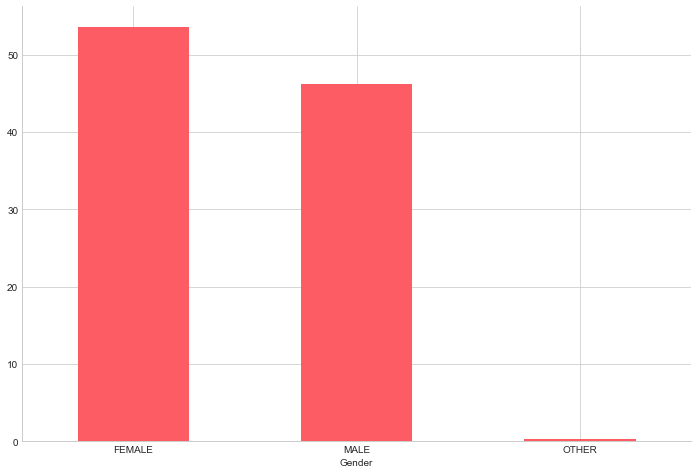

In [15]:
#Gender distribution of users
plt.figure(figsize=(12,8))
total = len(dftrainclean.index)
gender_percentage = dftrainclean.gender.value_counts()/total * 100
print("Gender Percentage:\n",gender_percentage)
print("\nGender Count:\n", dftrainclean.groupby('gender').size())
gender_percentage.plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

Destination Percentage:
 US       70.471570
other    10.983893
FR        5.565690
IT        3.013778
GB        2.658645
ES        2.579080
CA        1.602950
DE        1.309917
NL        0.892684
AU        0.677275
PT        0.244518
Name: country_destination, dtype: float64


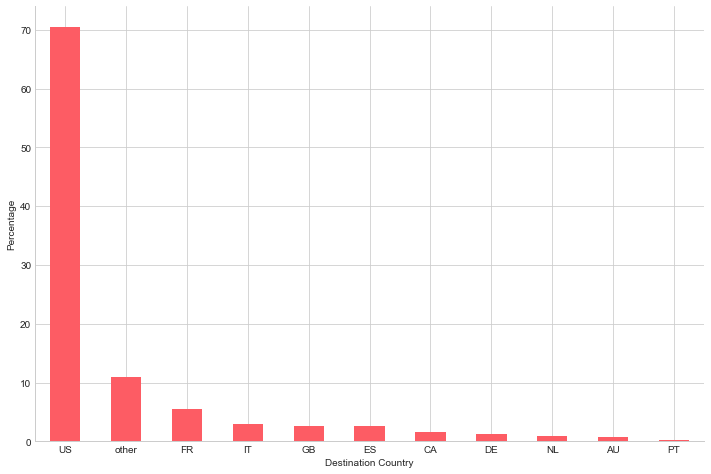

In [16]:
#Most popular destination choices
plt.figure(figsize=(12,8))
destination_percentage = dftrainclean.country_destination.value_counts()/total * 100
print("Destination Percentage:\n", destination_percentage)
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)

plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

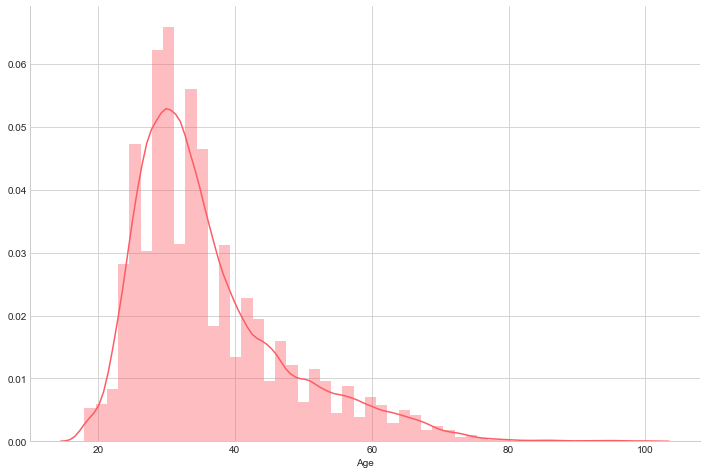

In [17]:
#Age distribution of users
plt.figure(figsize=(12,8))
sns.distplot(dftrainclean.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

In [18]:
#Age descriptive statistics
statage = dftrainclean.age.describe()
skewage = dftrainclean.age.skew()
print('Descriptive statistics:',statage)
print('Skewness:',skewage)

Descriptive statistics: count    51530.000000
mean        36.193712
std         11.206214
min         18.000000
25%         28.000000
50%         33.000000
75%         41.000000
max        100.000000
Name: age, dtype: float64
Skewness: 1.3093821520055404


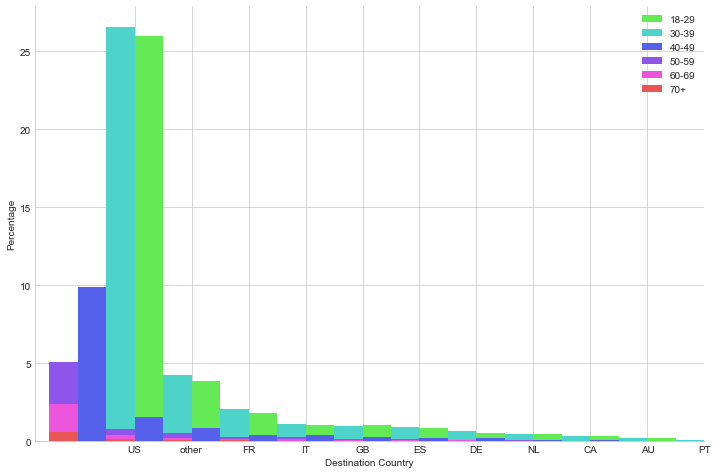

In [19]:
#Destination preferences based on age group
plt.figure(figsize=(12,8))

bin18 = sum(dftrainclean.loc[dftrainclean['18-29']==1, 'country_destination'].value_counts())
bin30 = sum(dftrainclean.loc[dftrainclean['30-39']==1, 'country_destination'].value_counts())
bin40 = sum(dftrainclean.loc[dftrainclean['40-49']==1, 'country_destination'].value_counts())
bin50 = sum(dftrainclean.loc[dftrainclean['50-59']==1, 'country_destination'].value_counts())
bin60 = sum(dftrainclean.loc[dftrainclean['60-69']==1, 'country_destination'].value_counts())
bin70 = sum(dftrainclean.loc[dftrainclean['70+']==1, 'country_destination'].value_counts())


b18 =  dftrainclean.loc[dftrainclean['18-29']==1, 'country_destination'].value_counts()/total*100
b30 = dftrainclean.loc[dftrainclean['30-39']==1, 'country_destination'].value_counts()/total*100
b40 = dftrainclean.loc[dftrainclean['40-49']==1, 'country_destination'].value_counts()/total*100
b50 = dftrainclean.loc[dftrainclean['50-59']==1, 'country_destination'].value_counts()/total*100
b60 = dftrainclean.loc[dftrainclean['60-69']==1, 'country_destination'].value_counts()/total*100
b70 = dftrainclean.loc[dftrainclean['70+']==1, 'country_destination'].value_counts()/total*100


b18.plot(kind='bar',  color='#63EA55', position=0, label='18-29', rot=0)
b30.plot(kind='bar', color='#4DD3C9', position=1, label='30-39', rot=0)
b40.plot(kind='bar',  color='#5561ea', position=2, label='40-49', rot=0)
b50.plot(kind='bar',  color='#8e55ea', position=3, label='50-59', rot=0)
b60.plot(kind='bar', color='#ea55db', position=3, label='60-69', rot=0)
b70.plot(kind='bar',  color='#ea5555', position=3, label='70+', rot=0)


plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()
plt.show()

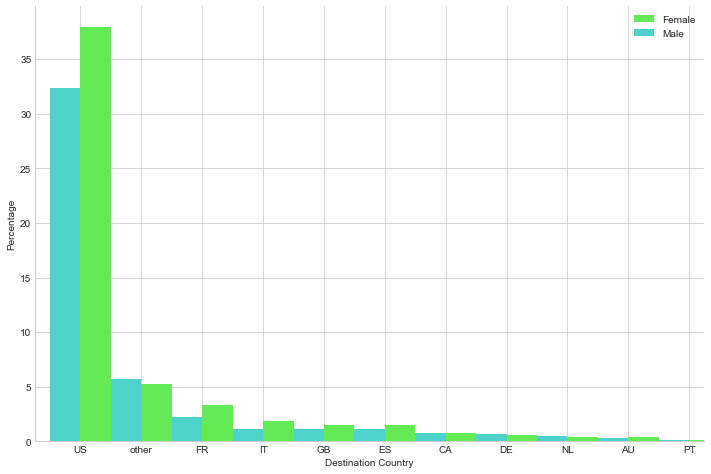

In [20]:
#Destination preferences based on age group
plt.figure(figsize=(12,8))

male = sum(dftrainclean.loc[dftrainclean['MALE']==1, 'country_destination'].value_counts())
female = sum(dftrainclean.loc[dftrainclean['FEMALE']==1, 'country_destination'].value_counts())


m =  dftrainclean.loc[dftrainclean['MALE']==1, 'country_destination'].value_counts()/total*100
f = dftrainclean.loc[dftrainclean['FEMALE']==1, 'country_destination'].value_counts()/total*100


f.plot(kind='bar', color='#63EA55', position=0, label='Female', rot=0)
m.plot(kind='bar',  color='#4DD3C9', position=1, label='Male', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()
plt.show()

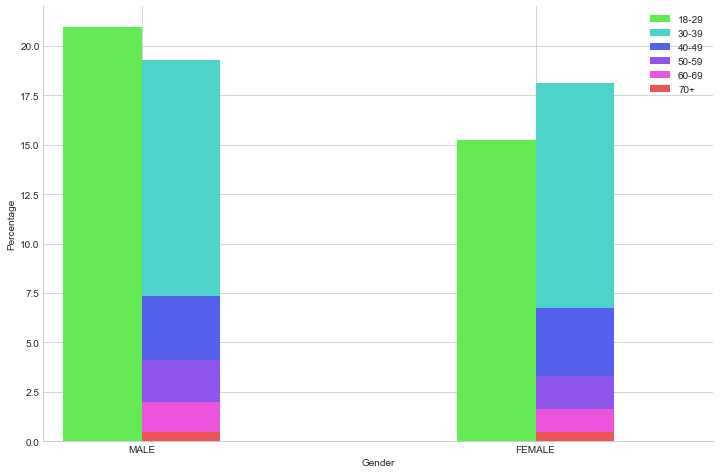

In [21]:
#Gender based on age group
plt.figure(figsize=(12,8))

bing18 = sum(dftrainclean.loc[dftrainclean['18-29']==1, 'gender'].value_counts())
bing30 = sum(dftrainclean.loc[dftrainclean['30-39']==1, 'gender'].value_counts())
bing40 = sum(dftrainclean.loc[dftrainclean['40-49']==1, 'gender'].value_counts())
bing50 = sum(dftrainclean.loc[dftrainclean['50-59']==1, 'gender'].value_counts())
bing60 = sum(dftrainclean.loc[dftrainclean['60-69']==1, 'gender'].value_counts())
bing70 = sum(dftrainclean.loc[dftrainclean['70+']==1, 'gender'].value_counts())


bg18 =  dftrainclean.loc[dftrainclean['18-29']==1, 'gender'].value_counts()/total*100
bg30 = dftrainclean.loc[dftrainclean['30-39']==1, 'gender'].value_counts()/total*100
bg40 = dftrainclean.loc[dftrainclean['40-49']==1, 'gender'].value_counts()/total*100
bg50 = dftrainclean.loc[dftrainclean['50-59']==1, 'gender'].value_counts()/total*100
bg60 = dftrainclean.loc[dftrainclean['60-69']==1, 'gender'].value_counts()/total*100
bg70 = dftrainclean.loc[dftrainclean['70+']==1, 'gender'].value_counts()/total*100


bg18.plot(kind='bar', width=0.2, color='#63EA55', position=1, label='18-29', rot=0)
bg30.plot(kind='bar', width=0.2, color='#4DD3C9', position=0, label='30-39', rot=0)
bg40.plot(kind='bar', width=0.2, color='#5561ea', position=0, label='40-49', rot=0)
bg50.plot(kind='bar', width=0.2, color='#8e55ea', position=0, label='50-59', rot=0)
bg60.plot(kind='bar', width=0.2, color='#ea55db', position=0, label='60-69', rot=0)
bg70.plot(kind='bar', width=0.2, color='#ea5555', position=0, label='70+', rot=0)


plt.legend()
plt.xlabel('Gender')
plt.ylabel('Percentage')
sns.despine()
plt.show()

# Model building and new cleaning

In [22]:
# Get data from csv
data_all = pd.read_csv('data/train_users_2.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])

In [23]:
# Dropping ids which are saved separately and date of first booking which is completely absent in the test data
data_all = data_all.drop(['id','date_first_booking'], axis=1)

In [24]:
#Data Cleaning
data_all.gender.replace('-unknown-', np.nan, inplace=True)
data_all.first_browser.replace('-unknown-', np.nan, inplace=True)

data_all.loc[data_all.age > 100, 'age'] = np.nan
data_all.loc[data_all.age < 18, 'age'] = np.nan

In [25]:
#### NEW CLEANING ####
# Splitting date time data for date account created
data_all['dac_year'] = data_all.date_account_created.dt.year
data_all['dac_month'] = data_all.date_account_created.dt.month
data_all['dac_day'] = data_all.date_account_created.dt.day

# Splitting date time data for time first active
data_all['tfa_year'] = data_all.timestamp_first_active.dt.year
data_all['tfa_month'] = data_all.timestamp_first_active.dt.month
data_all['tfa_day'] = data_all.timestamp_first_active.dt.day

data_all.drop('date_account_created',1, inplace=True)
data_all.drop('timestamp_first_active',1, inplace=True)

In [26]:
#### More efficient way of getting dummies
# Create categorical columns
features = ['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider',\
            'first_affiliate_tracked','signup_app','first_device_type','first_browser']

# get dummies
data_all = pd.get_dummies(data_all,columns=features)

data_all

,age,country_destination,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,NDF,2010,6,28,2009,3,19,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,NDF,2011,5,25,2009,5,23,0,1,...,0,0,0,0,0,0,0,0,0,0
2,56.0,US,2010,9,28,2009,6,9,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,other,2011,12,5,2009,10,31,1,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,US,2010,9,14,2009,12,8,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,32.0,NDF,2014,6,30,2014,6,30,0,1,...,0,0,0,0,0,0,0,0,0,0
213447,NaN,NDF,2014,6,30,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213448,32.0,NDF,2014,6,30,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0
213449,NaN,NDF,2014,6,30,2014,6,30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:

# Store country names
labels = data_all['country_destination'].values

X = data_all.drop(['country_destination'], axis=1)

#Create labels
labler = LabelEncoder()
y = pd.DataFrame(labler.fit_transform(labels),columns = ['country'])

# Splitting train and test for the classifier
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30)

## XGBoost Classifier decision tree


In [28]:
# Implementation of the classifier (decision tree)
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=22,
                    objective='multi:softprob',num_class=10, subsample=0.6, colsample_bytree=0.6, seed=0)               
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Results

### Feature Importance


<Figure size 720x576 with 0 Axes>

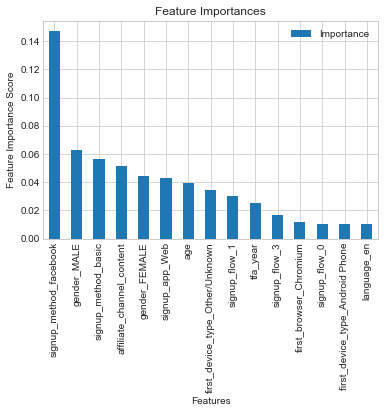

In [29]:
plt.figure(figsize=(10,8))
feat_imp = xgb.feature_importances_
feat = X_train.columns.tolist()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
res_df2 = res_df.iloc[:15]
res_df2.plot('Features', 'Importance', kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

### Accuracy for top prob destination


In [30]:
#Taking the highest probabilitiy destination
ids_max = []  #list of ids
cts_max = []  #list of countries
prob_max = []
for i in range(len(y_test)):
    idx_max = y_test.index[i]
    ids_max += [idx_max]
    cts_max += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:1].tolist()


In [31]:
sub_max = pd.DataFrame(np.column_stack((ids_max, cts_max)), columns=['id', 'country_pred'])
#Cleaning sub_max to merge with y_test, to get accuracy score
sub_max = sub_max.set_index(sub_max.id)
sub_max.index.names = ['index']
del sub_max['id']

In [32]:
#Revert labels back to country name
y_test_score = y_test.copy()
y_test_score['country2'] = labler.inverse_transform(y_test_score['country'])
del y_test_score['country']

In [33]:
def accuracy_rate(x,y):
    R = 0
    for i in range(len(y_test_score)):
        if x[i] == y[i]:
            R += 1
    return R/len(y_test_score)

In [34]:
a = y_test_score['country2'].values
b = sub_max['country_pred'].values

accuracy_top =accuracy_rate(a,b)
print('Accuracy Score = ',accuracy_rate(a,b))

Accuracy Score =  0.633846586295209


### Accuracy for top 2 destinations


In [35]:
#Taking the 3 classes with highest probabilities
ids_2 = []  #list of ids
cts_2 = []  #list of countries

for i in range(len(y_test)):
    idx = y_test.index[i]
    ids_2 += [idx] * 2
    cts_2 += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:2].tolist()
    
sub_2 = pd.DataFrame(np.column_stack((ids_2, cts_2)), columns=['id', 'country_pred'])

In [36]:
def accuracy_rate_top2(x,y): #x: test  y: pred
    R = 0
    for i in range(len(y_test_score)):
        if x[i] == y[i*2] or x[i] == y[i*2+1]:
            R += 1
    return R/len(y_test_score)

In [37]:
a4 = y_test_score['country2'].values
b4 = sub_2['country_pred'].values

accuracy_top2 = accuracy_rate_top2(a4,b4)
print('Accuracy Score = ',accuracy_rate_top2(a4,b4))

Accuracy Score =  0.8742738459616466


### Accuracy for top 3 destinations

In [38]:
#Taking the 3 classes with highest probabilities
ids_3 = []  #list of ids
cts_3 = []  #list of countries
prob_3 = []
for i in range(len(y_test)):
    idx = y_test.index[i]
    ids_3 += [idx] * 3
    cts_3 += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:3].tolist()
    
sub_3 = pd.DataFrame(np.column_stack((ids_3, cts_3)), columns=['id', 'country_pred'])

In [39]:
def accuracy_rate_top3(x,y): #x: test  y: pred
    R = 0
    for i in range(len(y_test_score)):
        if x[i] == y[i*3] or x[i] == y[i*3+1] or x[i] == y[i*3+2]:
            R += 1
    return R/len(y_test_score)

In [40]:
a2 = y_test_score['country2'].values
b2 = sub_3['country_pred'].values

accuracy_top3 = accuracy_rate_top3(a2,b2)
print('Accuracy Score = ',accuracy_rate_top3(a2,b2))

Accuracy Score =  0.9217783746642514


### Accuracy for top 4 destinations

In [41]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries

for i in range(len(y_test)):
    idx = y_test.index[i]
    ids += [idx] * 4
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:4].tolist()

sub_4 = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country_pred'])

In [42]:
def accuracy_rate_top4(x,y): #x: test  y: pred
    R = 0
    for i in range(len(y_test_score)):
        if x[i] == y[i*4] or x[i] == y[i*4+1] or x[i] == y[i*4+2] or x[i] == y[i*4+3]:
            R += 1
    return R/len(y_test_score)

In [43]:
a5 = y_test_score['country2'].values
b5 = sub_4['country_pred'].values

accuracy_top4 = accuracy_rate_top4(a5,b5)
print('Accuracy Score = ',accuracy_rate_top4(a5,b5))

Accuracy Score =  0.9444062714722968


### Accuracy for top 5 destinations


In [44]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
prob = []
for i in range(len(y_test)):
    idx = y_test.index[i]
    ids += [idx] * 5
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub_5 = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country_pred'])

In [45]:
def accuracy_rate_top5(x,y): #x: test  y: pred
    R = 0
    for i in range(len(y_test_score)):
        if x[i] == y[i*5] or x[i] == y[i*5+1] or x[i] == y[i*5+2] or x[i] == y[i*5+3] or x[i] == y[i*5+4]:
            R += 1
    return R/len(y_test_score)

In [46]:
a3 = y_test_score['country2'].values
b3 = sub_5['country_pred'].values

accuracy_top5 = accuracy_rate_top5(a3,b3)
print('Accuracy Score = ',accuracy_rate_top5(a3,b3))

Accuracy Score =  0.9583203198201012


### Plot model accuracy on number of destinations to market per client

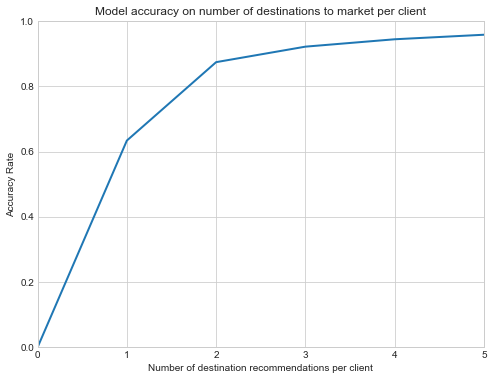

In [47]:
plt.figure(figsize=(8, 6))
accuracy_plot = [0,accuracy_top, accuracy_top2, accuracy_top3, accuracy_top4, accuracy_top5]
x_plot = [0,1,2,3,4,5]
plt.plot(x_plot,accuracy_plot, linewidth=2.0)
plt.xlim([0.0, 5.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Number of destination recommendations per client')
plt.ylabel('Accuracy Rate')
plt.title('Model accuracy on number of destinations to market per client')
plt.show()